# How to use **ddCRP**:  An example with synthetic data

This notebook is analogous to the documentation contained in the ReadMe.md file.  We begin by importing the necessary modules.  *ddCRP* contains the actual modeling algorithm, *Priors* contains the allowed prior models (Normal-Inverse-Chi-Squared and Normal-Inverse-Wishart), and *synthetic* contains methods for sampling synthetic data.

In [1]:
from ddCRP import ddCRP
from ddCRP import Priors
from ddCRP import synthetic

import numpy as np
np.random.seed(seed=2)

Next, we define some parameters for generating our synthetic data.  In this case, we are sampling our synthetic data from a *Normal-Inverse-Chi-Squared* model:

$$
(\mu,\sigma) \sim NI \chi^{2} (\mu_{0},\kappa_{0}; \nu_{0},\sigma^{2}_{0})
$$

where $\mu_{0}$ and $\kappa_{0}$ are priors on the feature means, while $\nu_{0}$ and $\sigma^{2}_{0}$ are priors on the feature variance.

Here, for each unique label in our synthetic data, we sample $d$ unique means and variances, and then sample feature vectors from a multivariate normal distribution with independent features (a.k.a. diagonal covariance matrix, and hence the Normal-Inverse-Chi-Squared model).

We could just as easily skip the Normal-Inverse-Chi-Squared aspect, and simply define a set of multivariate Normal distributions.  However, in this way, we can see how hyperparameter tuning of our ddCRP model relates to the hyperparameters of our synthetic data model.

In [2]:
# dimensionality of data
d = 5

mu = 0
kappa = 0.01
nu = 70
sigma= 1

Next, we initialize a **SampleSynthetic** object. ```kind=ell``` defines what type of synthetic data we are modeling.  Options for this parmeter include ```['ell', 'stripes', 'face', 'square']```.

In [3]:
synth = synthetic.SampleSynthetic(kind='face', d=d, mu0=0, kappa0=kappa, nu0=nu, sigma0=sigma)
synth.fit()

print('Attributes of synth: \n')
print(list(synth.__dict__.keys()))

Attributes of synth: 

['kind', 'd', 'mu0', 'kappa0', 'nu0', 'sigma0', 'z_', 'adj_list_', 'parcels_', 'params_', 'parcel_features_', 'features_']


We're specifically interested in ```z_```, ```adj_list_```, and ```features_```.  ```z_``` represents the ground truth label map of our synthetic data, ```adj_list_``` is the adjancey list of our samples, and ```features_``` are the multivariate feature vectors of our data.

Next, we initialize our prior model.  In this case, we'll use the **Normal-Inverse-Wishart** prior.  We need to define a multivariate mean vector prior $\bar{\mu_{0}}$, and a prior on the covariance matrix $\bar{\lambda_{0}}$ (for the inverse-Wishart distribution), along with $\kappa_{0}$ and $\nu_{0}$ as above.

In [4]:
mu_bar = np.zeros((d,))
lambda_bar = np.random.rand(d,d) + np.eye(d)

niw = Priors.NIW(mu0=mu_bar,kappa0=kappa,nu0=nu,lambda0=lambda_bar)

Finally, we can initialize our ddCRP model.  We first need to define a "concentration parameter", $\alpha$, that determines how likely points are to create new clusters or join an existing cluster.  We also provide some arguments that govern how many MCMC iterations we want to perform, and how often we want to sample and print out diagnostic information regarding the current state of our model.

In [5]:
alpha = 10

crp = ddCRP.ddCRP(alpha, model=niw, mcmc_passes=15, stats_interval=125)
crp.fit(synth.features_, synth.adj_list_)

Step: 0 Time: -1587252603.0114372 LP: -1064.6868011460178 K: 100 MaxLP: -1064.6868011460178
Step: 125 Time: -1587252602.3886862 LP: 184.7466365740466 K: 65 MaxLP: 184.7466365740466
Step: 250 Time: -1587252601.835362 LP: 988.7840042229969 K: 34 MaxLP: 988.7840042229969
Step: 375 Time: -1587252601.324366 LP: 1662.7312349012925 K: 22 MaxLP: 1662.7312349012925
Step: 500 Time: -1587252600.8339171 LP: 1868.0722210079293 K: 17 MaxLP: 1868.0722210079293
Step: 625 Time: -1587252600.272433 LP: 2030.0555895447383 K: 14 MaxLP: 2030.0555895447385
Step: 750 Time: -1587252599.7121432 LP: 2176.572271676666 K: 12 MaxLP: 2178.2580665198684
Step: 875 Time: -1587252599.156625 LP: 2294.6996825559954 K: 9 MaxLP: 2294.699682555996
Step: 1000 Time: -1587252598.598432 LP: 2601.569828585996 K: 8 MaxLP: 2601.569828585996
Step: 1125 Time: -1587252598.040662 LP: 2601.569828585996 K: 8 MaxLP: 2601.569828585996
Step: 1250 Time: -1587252597.4722722 LP: 2642.554447415887 K: 6 MaxLP: 2642.554447415887
Step: 1375 Time: 

Now we can print out the our ground truth label map, the *maximum-a-posterior* label map (i.e. the label configuration that maximizes the marginal evidence of our feature data, and the intial (essentially random) map that the ddCRP model starts out with.  The actual label values (colors) are arbitrary, and don't convey any special meaning.

Below the images are plots showing the number of clusters, marginal-evidence, and current *MAP*-evidence, each as a function of MCMC iterations (the sampling frequency is determined by the ```stats_interval``` parameter in the ddCRP model instantiation).

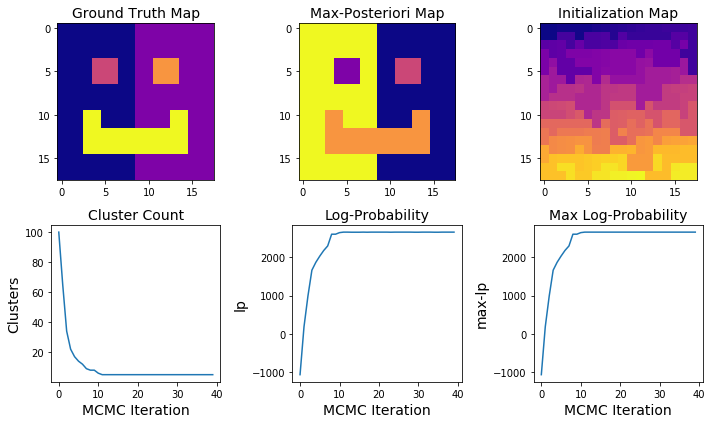

In [6]:
plot = synthetic.plot_synthetic(synth, crp, figsize=(10,6), cmap='plasma');
plot